<a href="https://colab.research.google.com/github/Guguinha383/analise-anomalia_temp-co2/blob/main/anomalia_temp_global.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌡️ Análise de Anomalias de Temperatura Global

## O que são Anomalias de Temperatura?

**Anomalias de temperatura** são desvios da temperatura média de um período de referência. Neste dataset, o **período base é 1951-1980**.

### Por que usar anomalias em vez de temperatura absoluta?

1. **Reduz variabilidade local**: Diferentes regiões têm climas muito diferentes. Uma anomalia de +2°C significa aquecimento relativo em qualquer local.

2. **Facilita comparações**: É mais fácil comparar tendências entre regiões usando desvios da média local.

3. **Melhor para análise de tendências**: Anomalias revelam mudanças climáticas de longo prazo de forma mais clara.

4. **Reduz ruído de dados**: Estações com dados incompletos têm menos impacto quando usamos anomalias.

### Fonte dos Dados
- **Temperatura Global**: NASA GISS Surface Temperature Analysis (GISTEMP)
- **CO₂ Atmosférico**: NOAA Global Monitoring Laboratory
- **ONI (Oceanic Niño Index)**: NOAA Climate Prediction Center

## 1. Importação de Bibliotecas

In [ ]:
!pip install -q pingouin lets_plot

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 910.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import statsmodels.api as sm
import pingouin as pg

from lets_plot import *
from matplotlib.ticker import MultipleLocator

from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson


LetsPlot.setup_html(no_js=True)

plt.style.use(
    "https://raw.githubusercontent.com/aeturrell/core_python/main/plot_style.txt"
)

## 2. Carregamento e Preparação dos Dados

In [ ]:
df = (
    pd.read_csv(
        "/content/dados_anomalia.csv",
        skiprows=1,
        na_values="***"
    )
    .rename(columns={
        "Year": "Ano",
        "J-D": "anomalia_anual"
    })
    .set_index('Ano')
)

df.head(6)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,anomalia_anual,D-N,DJF,MAM,JJA,SON
Ano,,,,,,,,,,,,,,,,,,
1880,-0.19,-0.25,-0.10,-0.17,-0.11,-0.22,-0.19,-0.11,-0.15,-0.24,-0.23,-0.18,-0.18,NaN,NaN,-0.13,-0.17,-0.21
1881,-0.20,-0.15,0.03,0.04,0.05,-0.19,0.00,-0.04,-0.16,-0.22,-0.19,-0.07,-0.09,-0.10,-0.18,0.04,-0.08,-0.19
1882,0.15,0.13,0.04,-0.17,-0.15,-0.23,-0.17,-0.08,-0.15,-0.24,-0.17,-0.36,-0.12,-0.09,0.07,-0.09,-0.16,-0.19
1883,-0.30,-0.37,-0.13,-0.18,-0.17,-0.08,-0.07,-0.14,-0.21,-0.11,-0.23,-0.11,-0.18,-0.20,-0.34,-0.16,-0.10,-0.19
1884,-0.13,-0.08,-0.36,-0.41,-0.34,-0.36,-0.30,-0.27,-0.27,-0.25,-0.34,-0.31,-0.29,-0.27,-0.11,-0.37,-0.31,-0.29
1885,-0.59,-0.34,-0.27,-0.42,-0.46,-0.44,-0.34,-0.32,-0.29,-0.24,-0.24,-0.11,-0.34,-0.35,-0.41,-0.38,-0.37,-0.26


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 1880 to 2025
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Jan             146 non-null    float64
 1   Feb             146 non-null    float64
 2   Mar             146 non-null    float64
 3   Apr             146 non-null    float64
 4   May             146 non-null    float64
 5   Jun             146 non-null    float64
 6   Jul             146 non-null    float64
 7   Aug             146 non-null    float64
 8   Sep             146 non-null    float64
 9   Oct             146 non-null    float64
 10  Nov             146 non-null    float64
 11  Dec             146 non-null    float64
 12  anomalia_anual  146 non-null    float64
 13  D-N             145 non-null    float64
 14  DJF             145 non-null    float64
 15  MAM             146 non-null    float64
 16  JJA             146 non-null    float64
 17  SON             146 non-null    floa

## 3. Análise Exploratória de Anomalia de Temperatura

In [ ]:
print("Estatísticas das Anomalias de Temperatura (°C):")
df.describe().drop('count').rename(index={
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    '25%': '25%',
    '50%': 'Mediana',
    '75%': '75%',
    'max': 'Máximo'
}).round(3)


Estatísticas das Anomalias de Temperatura (°C):


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,anomalia_anual,D-N,DJF,MAM,JJA,SON
Média,0.078,0.085,0.104,0.076,0.065,0.053,0.077,0.077,0.083,0.107,0.100,0.073,0.082,0.082,0.078,0.081,0.069,0.097
Desvio Padrão,0.447,0.452,0.458,0.420,0.397,0.396,0.379,0.397,0.399,0.403,0.412,0.426,0.402,0.403,0.431,0.421,0.387,0.400
Mínimo,-0.810,-0.630,-0.640,-0.600,-0.560,-0.520,-0.520,-0.550,-0.580,-0.580,-0.570,-0.820,-0.490,-0.500,-0.680,-0.580,-0.500,-0.520
25%,-0.248,-0.230,-0.230,-0.250,-0.240,-0.248,-0.190,-0.218,-0.190,-0.198,-0.178,-0.218,-0.200,-0.220,-0.230,-0.258,-0.218,-0.190
Mediana,-0.010,-0.035,0.015,-0.015,-0.035,-0.050,-0.030,-0.040,-0.055,0.010,0.020,-0.040,-0.030,-0.040,-0.030,-0.015,-0.040,-0.015
75%,0.320,0.398,0.352,0.298,0.280,0.268,0.290,0.305,0.272,0.268,0.288,0.358,0.318,0.300,0.370,0.310,0.310,0.280
Máximo,1.380,1.440,1.390,1.310,1.150,1.200,1.200,1.290,1.480,1.340,1.400,1.370,1.280,1.290,1.360,1.280,1.230,1.410


In [ ]:
print(f"Anomalia média: {df['anomalia_anual'].mean():.3f}°C")
print(f"Aquecimento total: {df['anomalia_anual'].iloc[-1] - df['anomalia_anual'].iloc[0]:.2f}°C")
print(f"Ano mais quente: {df['anomalia_anual'].idxmax()} ({df['anomalia_anual'].max():.2f}°C)")
print(f"Anos acima de +1°C: {(df['anomalia_anual'] > 1.0).sum()} anos")

Anomalia média: 0.082°C
Aquecimento total: 1.37°C
Ano mais quente: 2024 (1.28°C)
Anos acima de +1°C: 5 anos


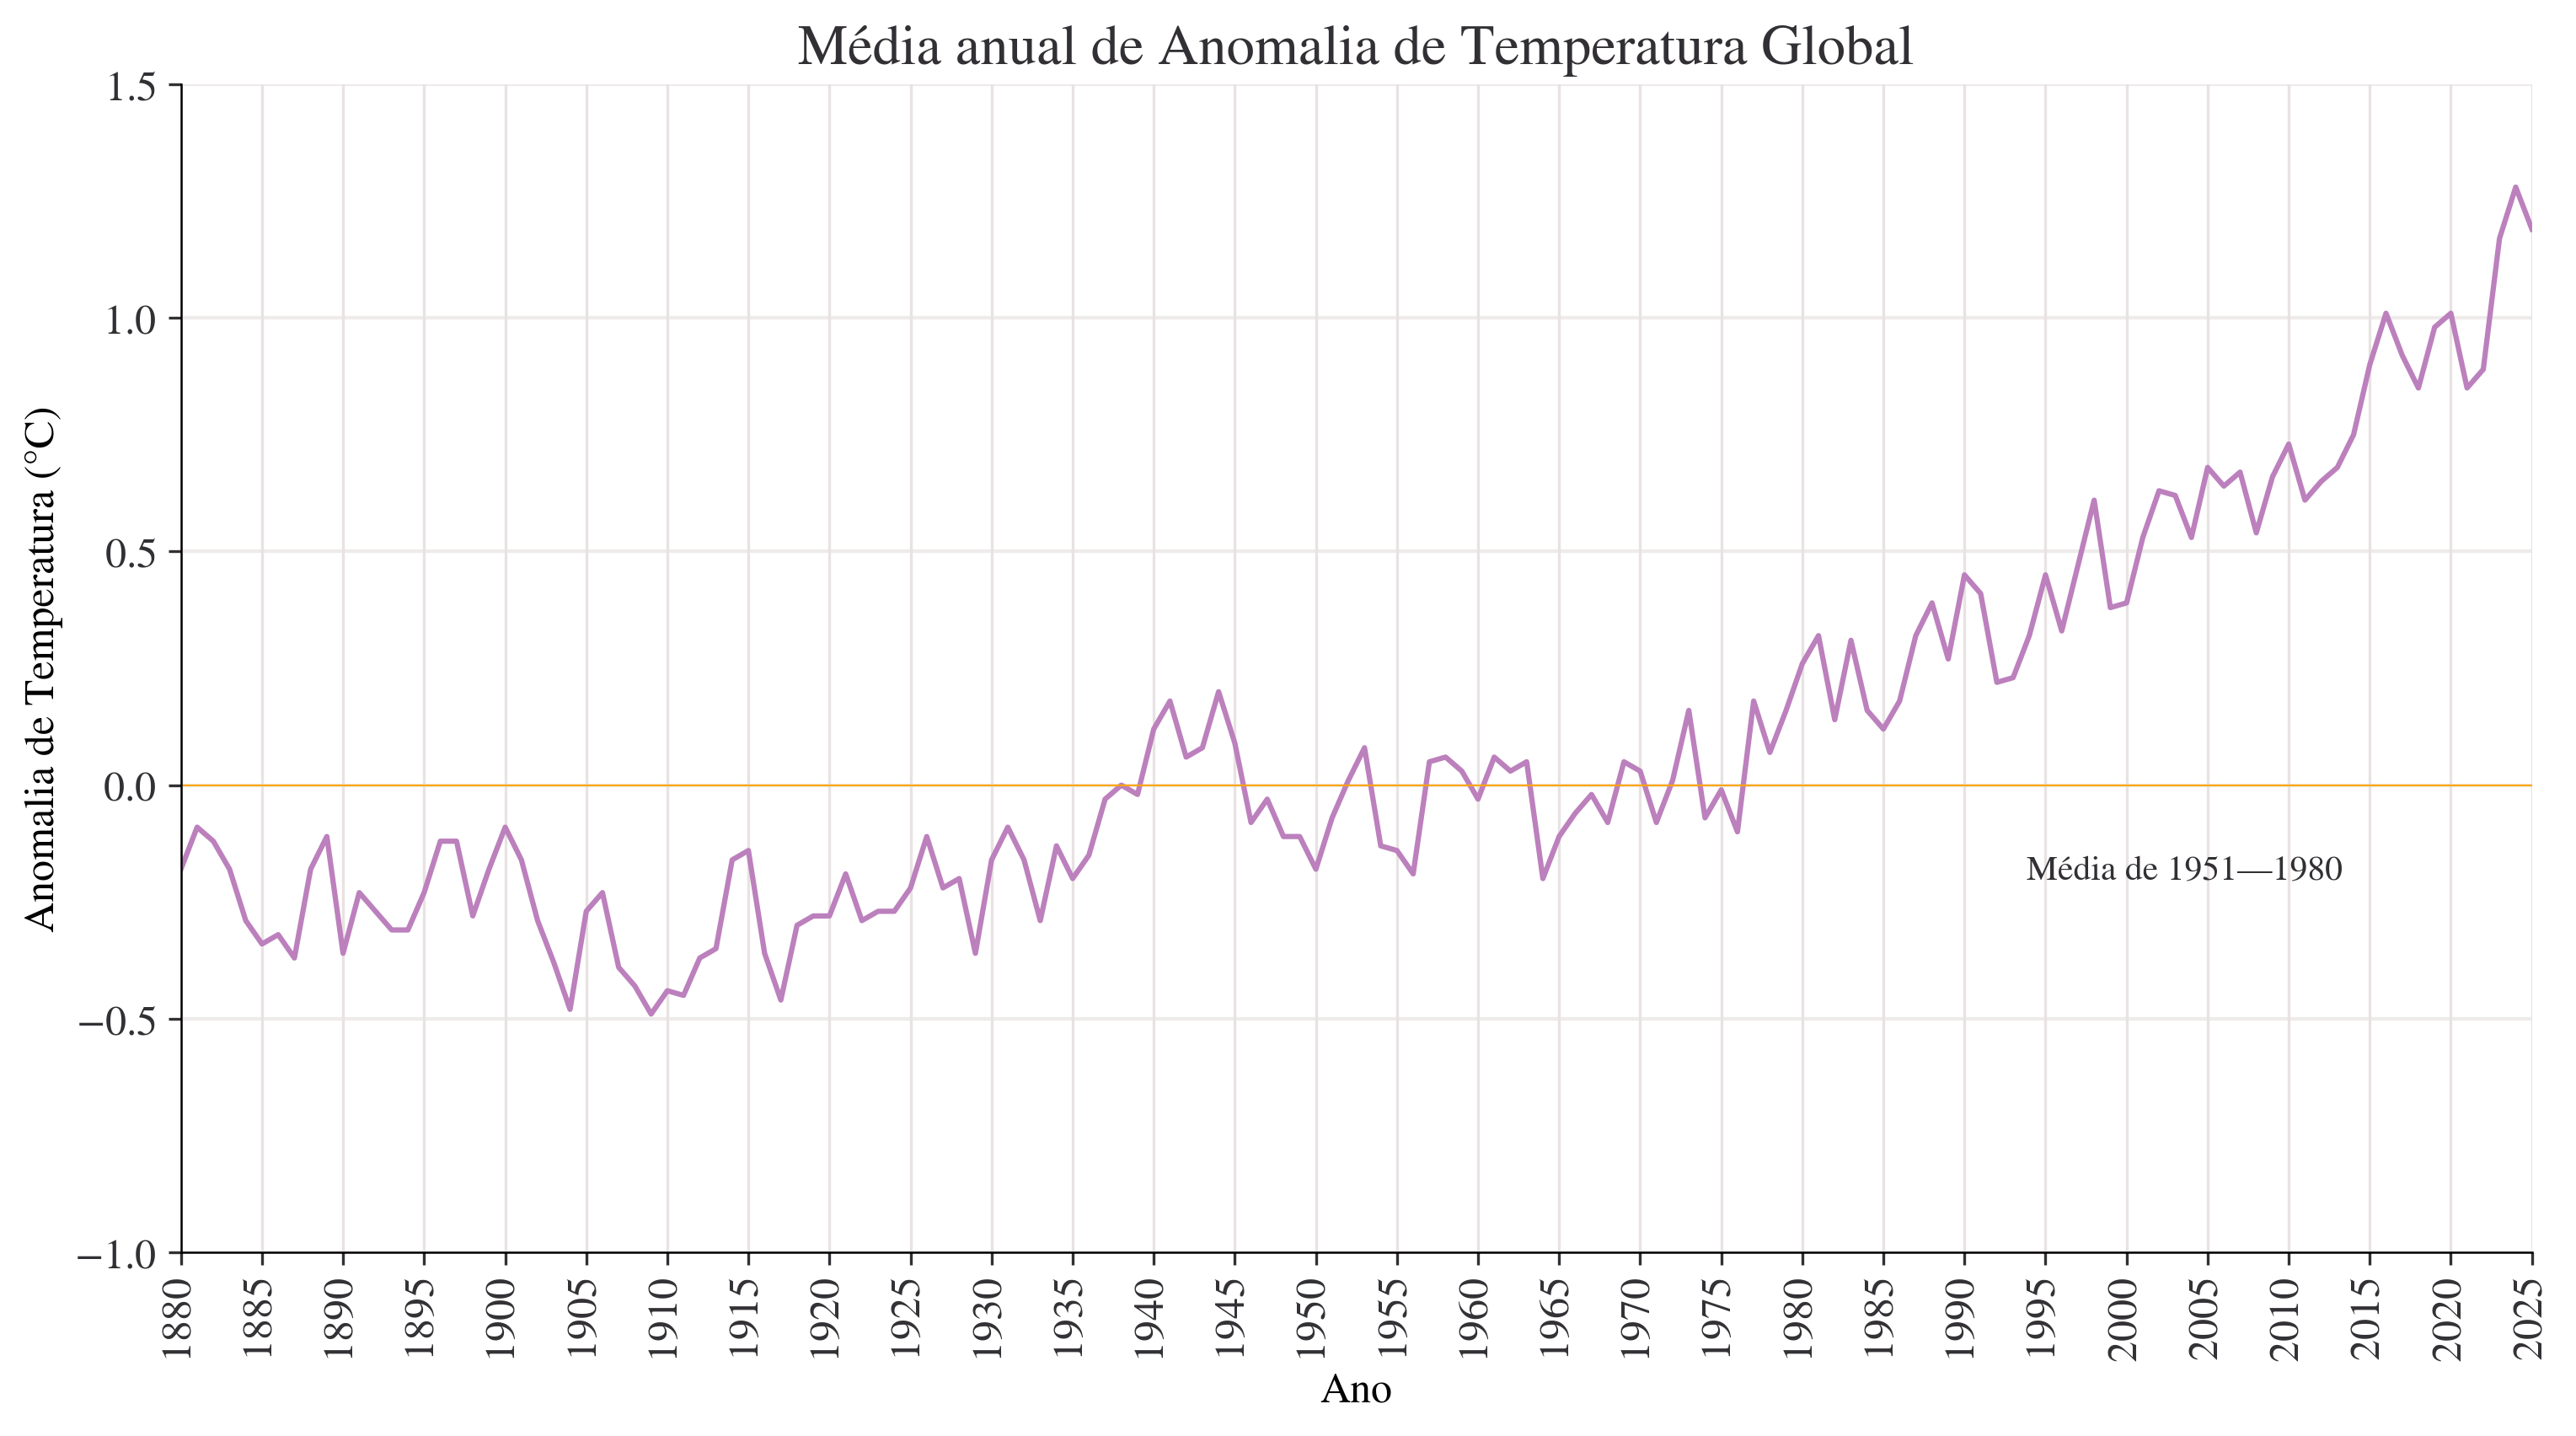

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
df["anomalia_anual"].plot(ax=ax, linewidth = 1.5)
ax.set_ylabel("Anomalia de Temperatura (°C)")
ax.set_xlabel("Ano")

ax.axhline(0, color="orange", linewidth = 0.5)
ax.annotate("Média de 1951—1980", xy=(0.668, -0.2), xycoords=("figure fraction", "data"))

ax.set_title("Média anual de Anomalia de Temperatura Global", loc="center")
ax.set_xlim(df.index.min(), df.index.max())

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_ylim(-1, 1.5)
ax.grid(True, alpha=0.7, linewidth=1, axis='y')

plt.xticks(rotation=90)

plt.show()

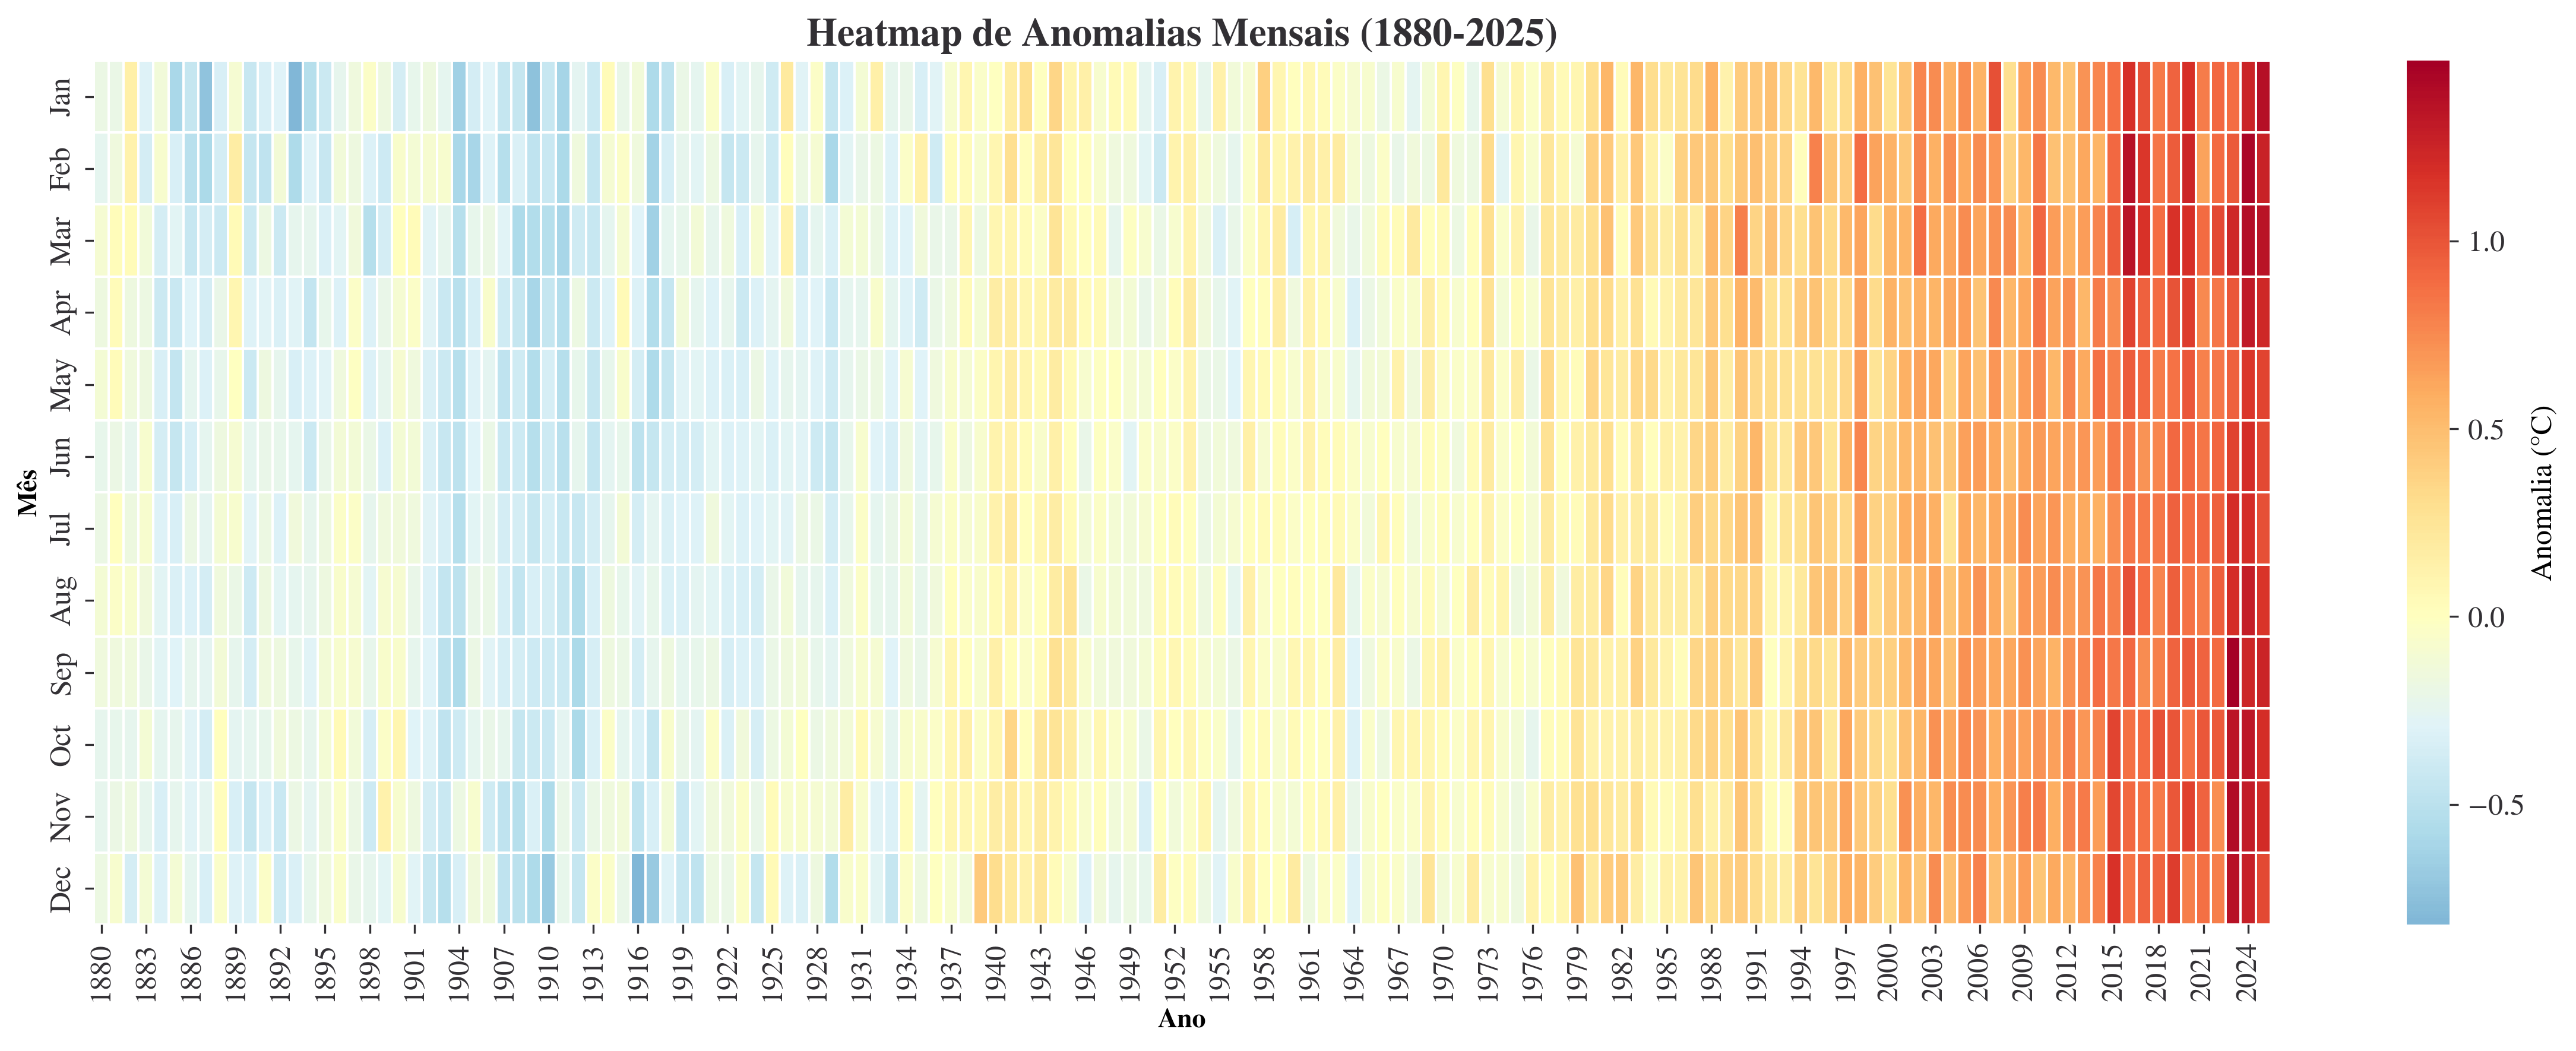

In [ ]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dados_heatmap = df.loc[1880:, meses].T

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(dados_heatmap, cmap='RdYlBu_r', center=0,
            cbar_kws={'label': 'Anomalia (°C)'},
            linewidths=0.5, ax=ax)

ax.set_title('Heatmap de Anomalias Mensais (1880-2025)',
             fontsize=16, fontweight='bold', loc ='center')
ax.set_xlabel('Ano', fontsize=11, fontweight='bold')
ax.set_ylabel('Mês', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
df["periodo"] = pd.cut(
    df.index,
    bins=[1880,1921, 1950, 1980, 2010, 2025],
    labels=["1880—1921", "1921—1950", "1951—1980", "1981—2010", "2011—2025"],
    ordered=True,
)
df["periodo"].tail(20)

estatisticas_periodos = df.groupby('periodo', observed = True)['anomalia_anual'].agg([
    ('Média', 'mean'),
    ('Mediana', 'median'),
    ('Desvio Padrão', 'std'),
    ('Mínimo', 'min'),
    ('Máximo', 'max')
]).round(3)

print("Estatísticas por Período (Anomalia Anual):")
print(estatisticas_periodos)

Estatísticas por Período (Anomalia Anual):
           Média  Mediana  Desvio Padrão  Mínimo  Máximo
periodo                                                 
1880—1921 -0.278    -0.28          0.115   -0.49   -0.09
1921—1950 -0.102    -0.11          0.147   -0.36    0.20
1951—1980  0.000     0.01          0.109   -0.20    0.26
1981—2010  0.423     0.40          0.180    0.12    0.73
2011—2025  0.916     0.90          0.198    0.61    1.28


In [ ]:
JJA = ["Jun", "Jul", "Aug"]
df[JJA].stack()

Ano      
1880  Jun   -0.22
      Jul   -0.19
      Aug   -0.11
1881  Jun   -0.19
      Jul    0.00
             ... 
2024  Jul    1.20
      Aug    1.29
2025  Jun    1.05
      Jul    1.02
      Aug    1.16
Length: 438, dtype: float64

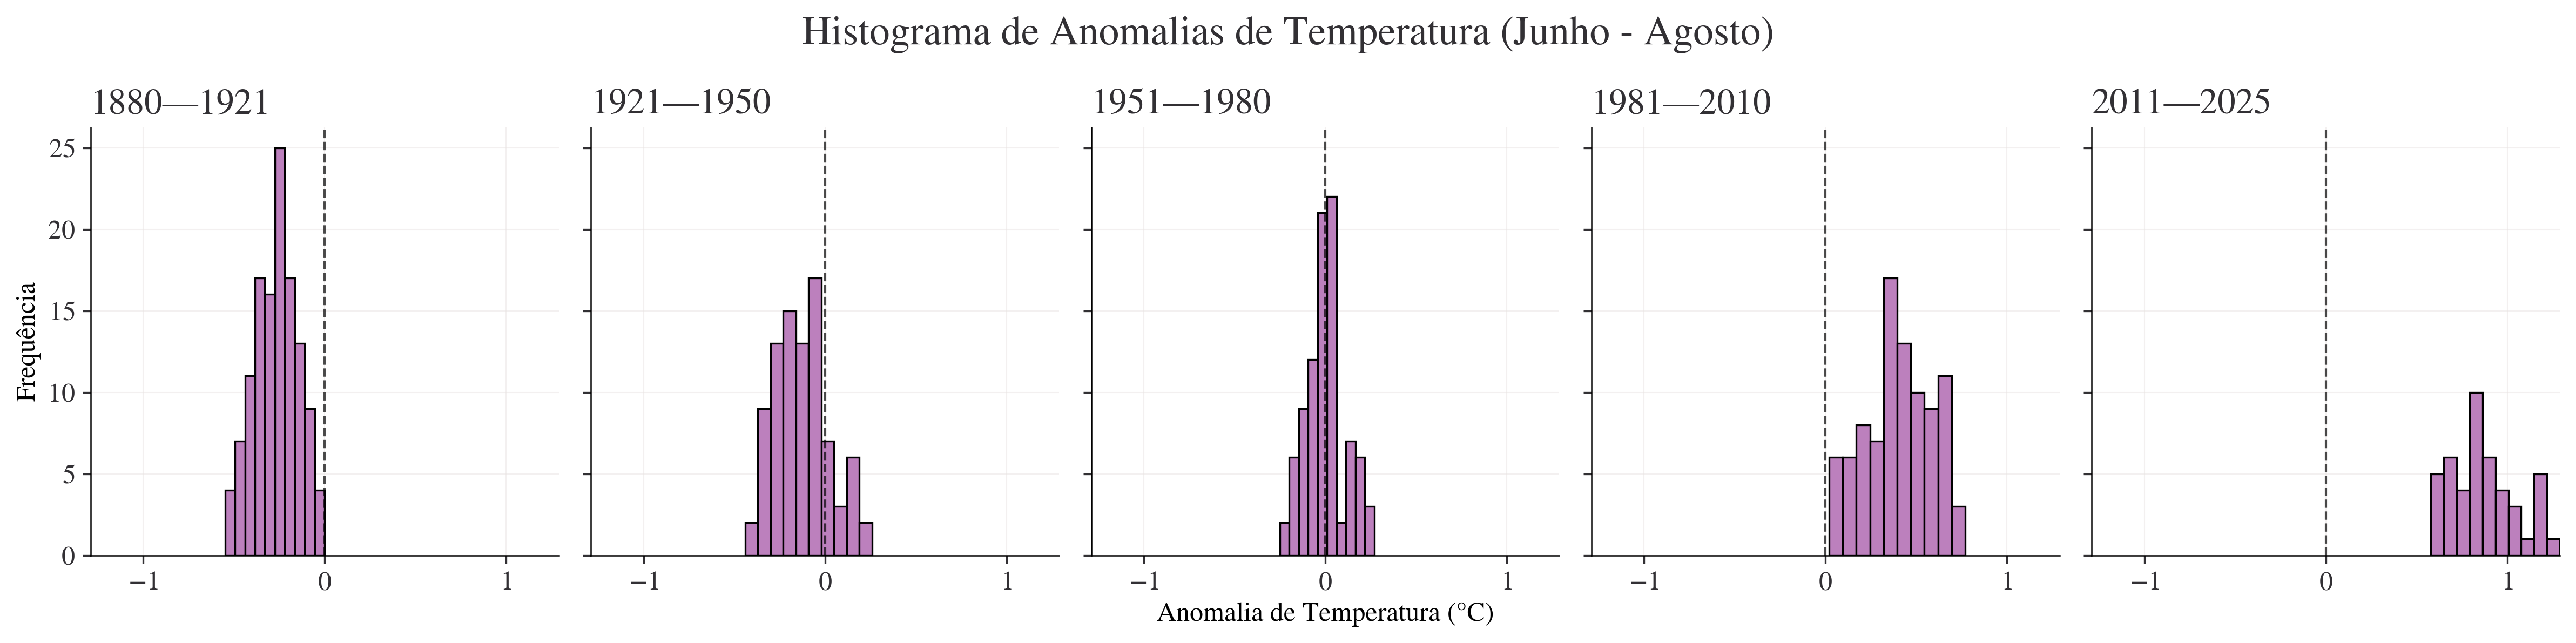

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(16, 4), sharex=True, sharey=True)

max_abs = max(abs(df[JJA].min().min()), abs(df[JJA].max().max()))

for ax, periodo in zip(axes, df["periodo"].dropna().unique()):
    df.loc[df["periodo"] == periodo, JJA].stack().hist(
        ax=ax,
        edgecolor = 'black',
        linewidth = 0.8
        )
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    ax.set_title(periodo)
    ax.grid(True, alpha=0.5, linewidth=0.5)
    ax.set_xlim(-max_abs, max_abs)


plt.suptitle("Histograma de Anomalias de Temperatura (Junho - Agosto)")
axes[2].set_xlabel('Anomalia de Temperatura (°C)', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)

plt.tight_layout();

In [ ]:
temp_meses = df.loc[(df.index >= 1951) & (df.index <= 1980), "Jan":"Dec"]

temp_meses = (
    temp_meses.stack()
    .reset_index()
    .rename(columns={"level_1": "mês", 0: "valores"})
)
temp_meses
print(temp_meses)

quartis = [0.3, 0.7]
percentis = np.quantile(temp_meses["valores"], q=quartis)

print(f"O limite inferior de {quartis[0]*100}% é {percentis[0]:.2f}")
print(f"O limite superior de {quartis[1]*100}% é {percentis[1]:.2f}")

      Ano  mês  valores
0    1951  Jan    -0.34
1    1951  Feb    -0.41
2    1951  Mar    -0.20
3    1951  Apr    -0.14
4    1951  May     0.00
..    ...  ...      ...
355  1980  Aug     0.18
356  1980  Sep     0.20
357  1980  Oct     0.13
358  1980  Nov     0.29
359  1980  Dec     0.21

[360 rows x 3 columns]
O limite inferior de 30.0% é -0.07
O limite superior de 70.0% é 0.07


In [ ]:
temp_meses = df.loc[(df.index >= 1981) & (df.index <= 2010), "Jan":"Dec"]

temp_meses = (
    temp_meses.stack()
    .reset_index()
    .rename(columns={"level_1": "mês", 0: "valores"})
)
temp_meses
print(temp_meses)

quartis = [0.3, 0.7]
percentis = np.quantile(temp_meses["valores"], q=quartis)

print(f"O limite inferior de {quartis[0]*100}% é {percentis[0]:.2f}")
print(f"O limite superior de {quartis[1]*100}% é {percentis[1]:.2f}")

      Ano  mês  valores
0    1981  Jan     0.53
1    1981  Feb     0.42
2    1981  Mar     0.48
3    1981  Apr     0.32
4    1981  May     0.24
..    ...  ...      ...
355  2010  Aug     0.67
356  2010  Sep     0.63
357  2010  Oct     0.71
358  2010  Nov     0.82
359  2010  Dec     0.45

[360 rows x 3 columns]
O limite inferior de 30.0% é 0.30
O limite superior de 70.0% é 0.54


In [ ]:
entradas_q30 = temp_meses["valores"] < percentis[0]
proporcao_q30 = entradas_q30.mean()
print(
    f"A proporção abaixo de {percentis[0]:.2f} é {proporcao_q30*100:.2f}%"
)

proporcao_q70 = (temp_meses ["valores"] > percentis[1]).mean()
print(f"A proporção acima de {percentis[1]} é {proporcao_q70*100:.2f}%")

A proporção abaixo de 0.30 é 28.33%
A proporção acima de 0.5429999999999998 é 30.00%


In [ ]:
temp_meses = (
    df.loc[:, "DJF":"SON"]
    .stack()
    .reset_index()
    .rename(columns={"level_1": "Trimestre", 0: "Valores"})
)
temp_meses["periodo"] = pd.cut(
    temp_meses["Ano"],
    bins=[1921, 1950, 1980, 2010, 2025],
    labels=["1921-1950", "1951-1980", "1981-2010","2011-2025"],
    ordered=True,
)

temp_meses.tail()

,Ano,Trimestre,Valores,periodo
578,2024,SON,1.29,2011-2025
579,2025,DJF,1.30,2011-2025
580,2025,MAM,1.22,2011-2025
581,2025,JJA,1.08,2011-2025
582,2025,SON,1.22,2011-2025


In [ ]:
grp_mean_var = (
    temp_meses.groupby(["Trimestre", "periodo"], observed=False)["Valores"]
    .agg(["mean", "var"])
    .rename(columns={"mean": "média", "var": "variância"})
)

grp_mean_var

média  variância
Trimestre periodo                       
DJF       1921-1950 -0.100690   0.036350
          1951-1980 -0.005333   0.025384
          1981-2010  0.446000   0.037459
          2011-2025  0.904667   0.075470
JJA       1921-1950 -0.131724   0.022136
          1951-1980 -0.000333   0.009369
          1981-2010  0.400000   0.033248
          2011-2025  0.869333   0.031821
MAM       1921-1950 -0.119655   0.025675
          1951-1980 -0.000333   0.024590
          1981-2010  0.442667   0.033924
          2011-2025  0.930000   0.043971
SON       1921-1950 -0.055517   0.020318
          1951-1980 -0.001000   0.012285
          1981-2010  0.401000   0.047168
          2011-2025  0.947333   0.045992

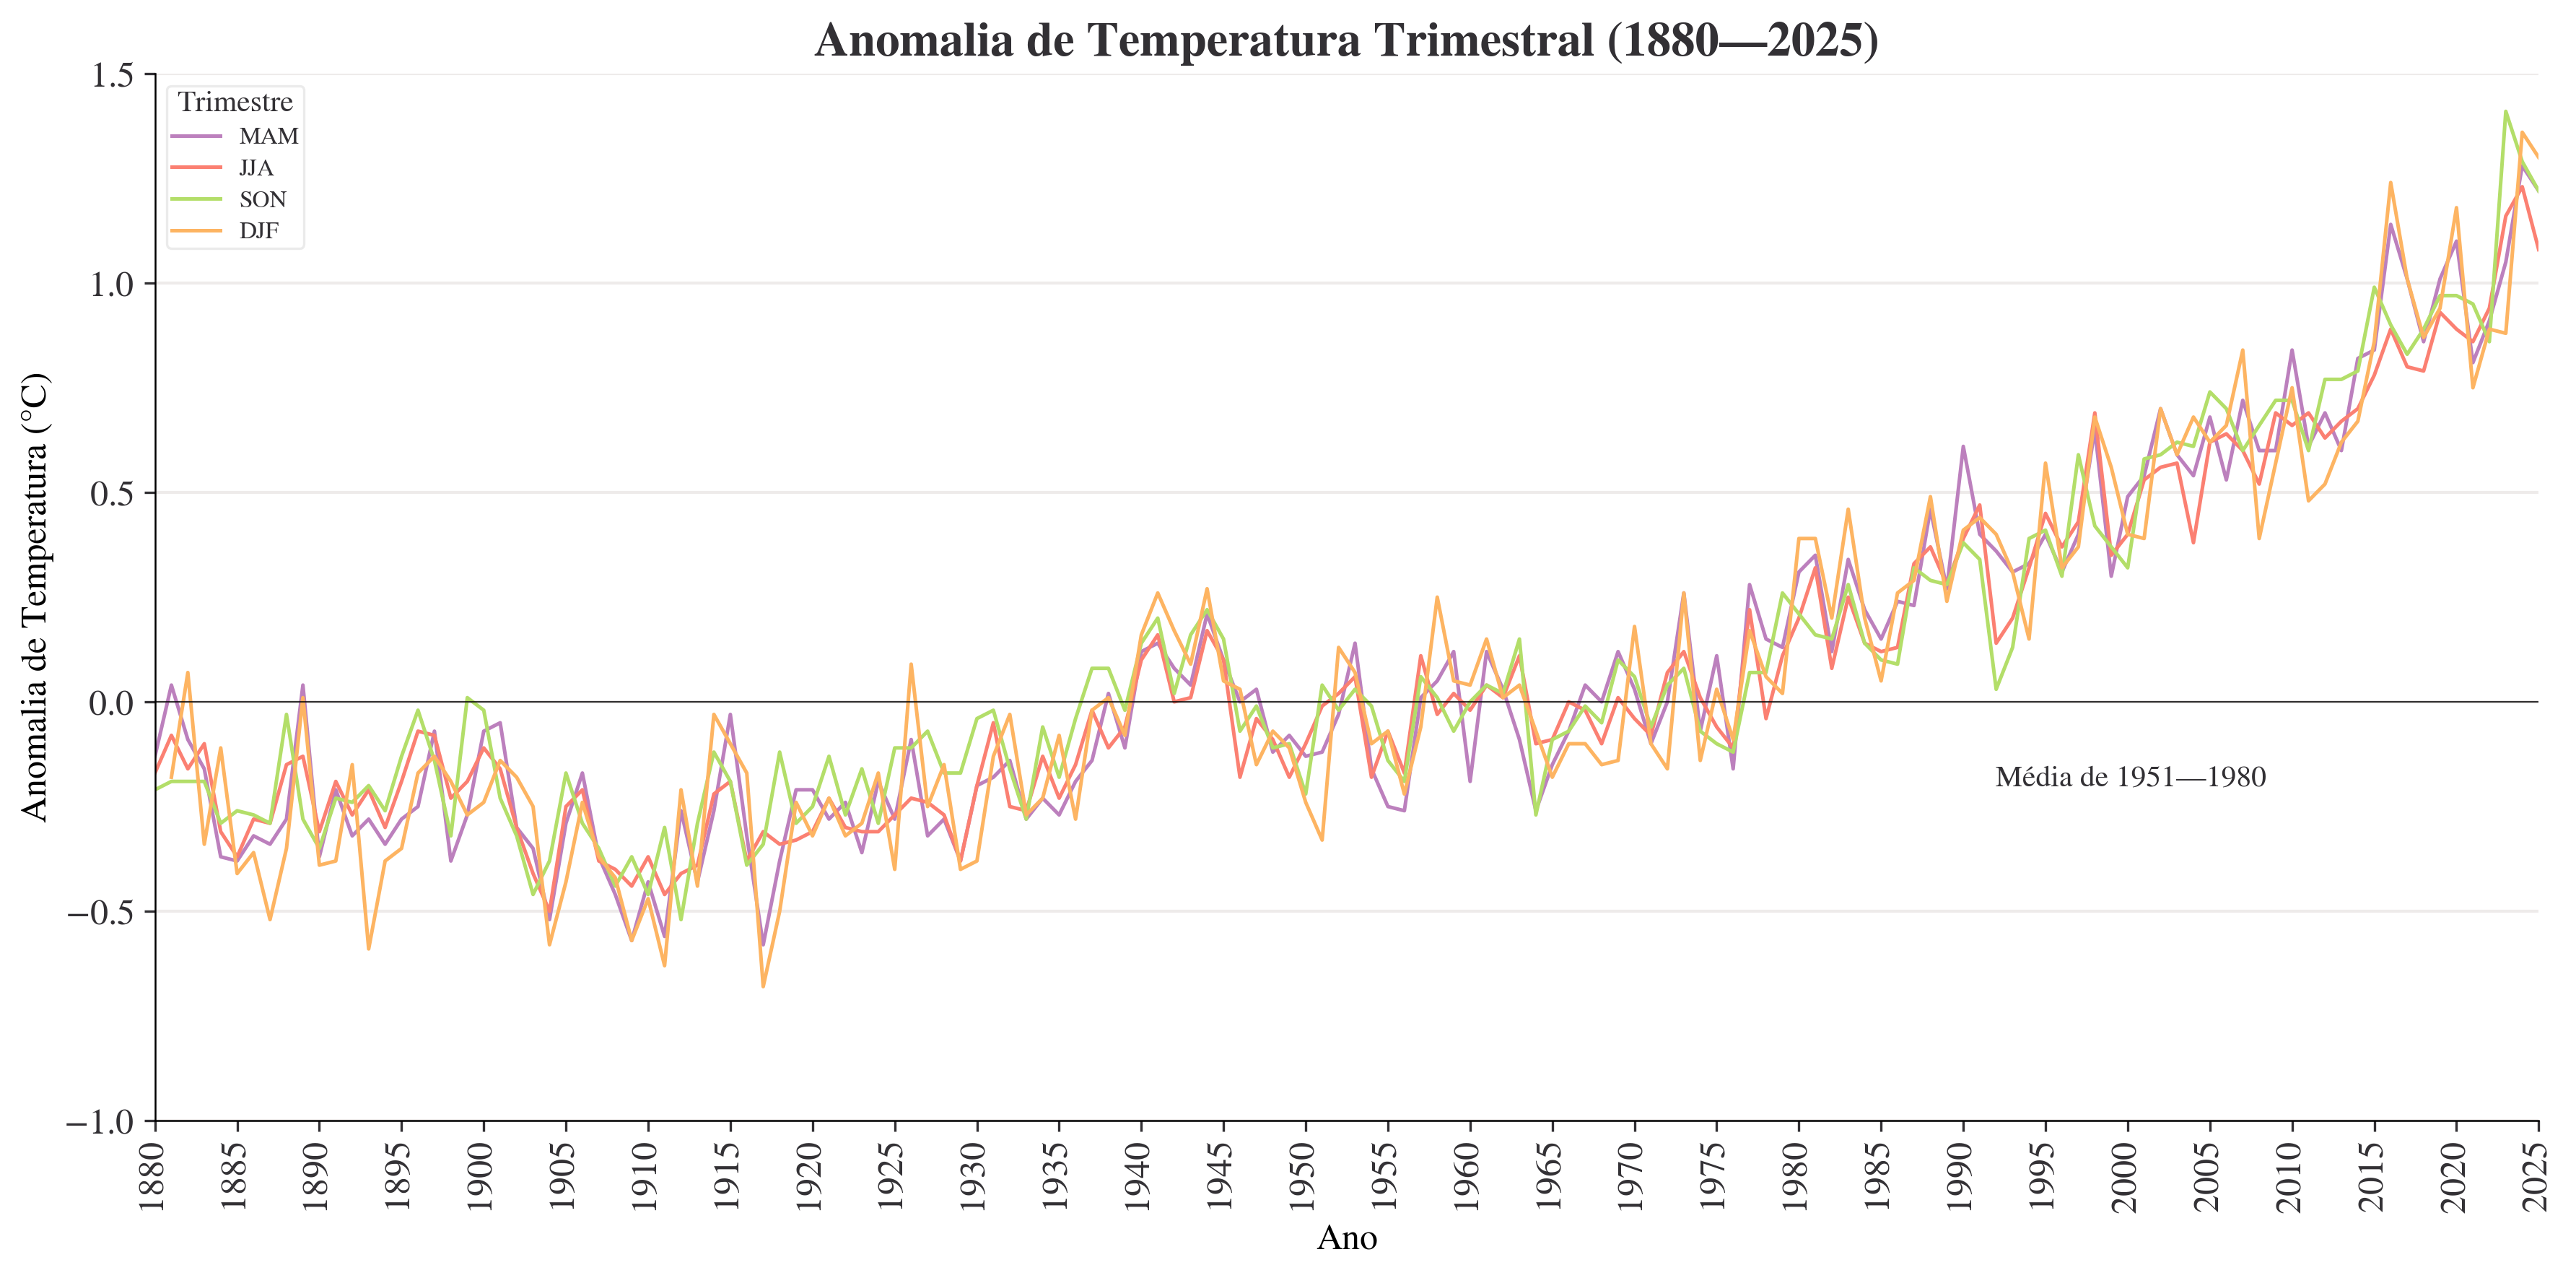

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for trimestre in temp_meses['Trimestre'].unique():
    dados_tri = temp_meses[temp_meses['Trimestre'] == trimestre]
    ax.plot(dados_tri['Ano'], dados_tri['Valores'], label=trimestre, linewidth=1.2)

min_ano = temp_meses['Ano'].min()
max_ano = temp_meses['Ano'].max()

ax.set_title(f"Anomalia de Temperatura Trimestral ({min_ano}—{max_ano})", loc="center", fontweight='bold')
ax.set_ylabel("Anomalia de Temperatura (°C)")
ax.set_xlabel("Ano")

ax.axhline(0, color="black", linewidth=0.5, alpha=0.8)
ax.annotate("Média de 1951—1980", xy=(0.768, -0.2), xycoords=("figure fraction", "data"))

ax.set_xlim(min_ano, max_ano)
ax.set_ylim(-1, 1.5)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.grid(True, alpha=0.7, linewidth=1, axis='y')

ax.legend(title="Trimestre", frameon=True)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## 4. Análise de CO2
Nesta etapa, o objetivo é analisar se o aumento de CO2 se há causalidade entre a anomalia de temperatura anual

In [ ]:
df_co2 = (
    pd.read_csv(
        "https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true",
        storage_options={'User-Agent': 'Our World In Data data fetch/1.0'}
    )
    .rename(columns={"year": "Ano", "entity": "paises", "emissions_total": "total_emissoes"})
    .drop('code', axis=1)
    .groupby('Ano')['total_emissoes'].sum()
    .div(1e9)
    .reset_index()
)
df_co2

,Ano,total_emissoes
0,1750,0.055836
1,1751,0.056443
2,1752,0.057031
3,1753,0.057663
4,1754,0.058401
...,...,...
270,2020,226.123155
271,2021,236.932334
272,2022,240.370224
273,2023,242.955626


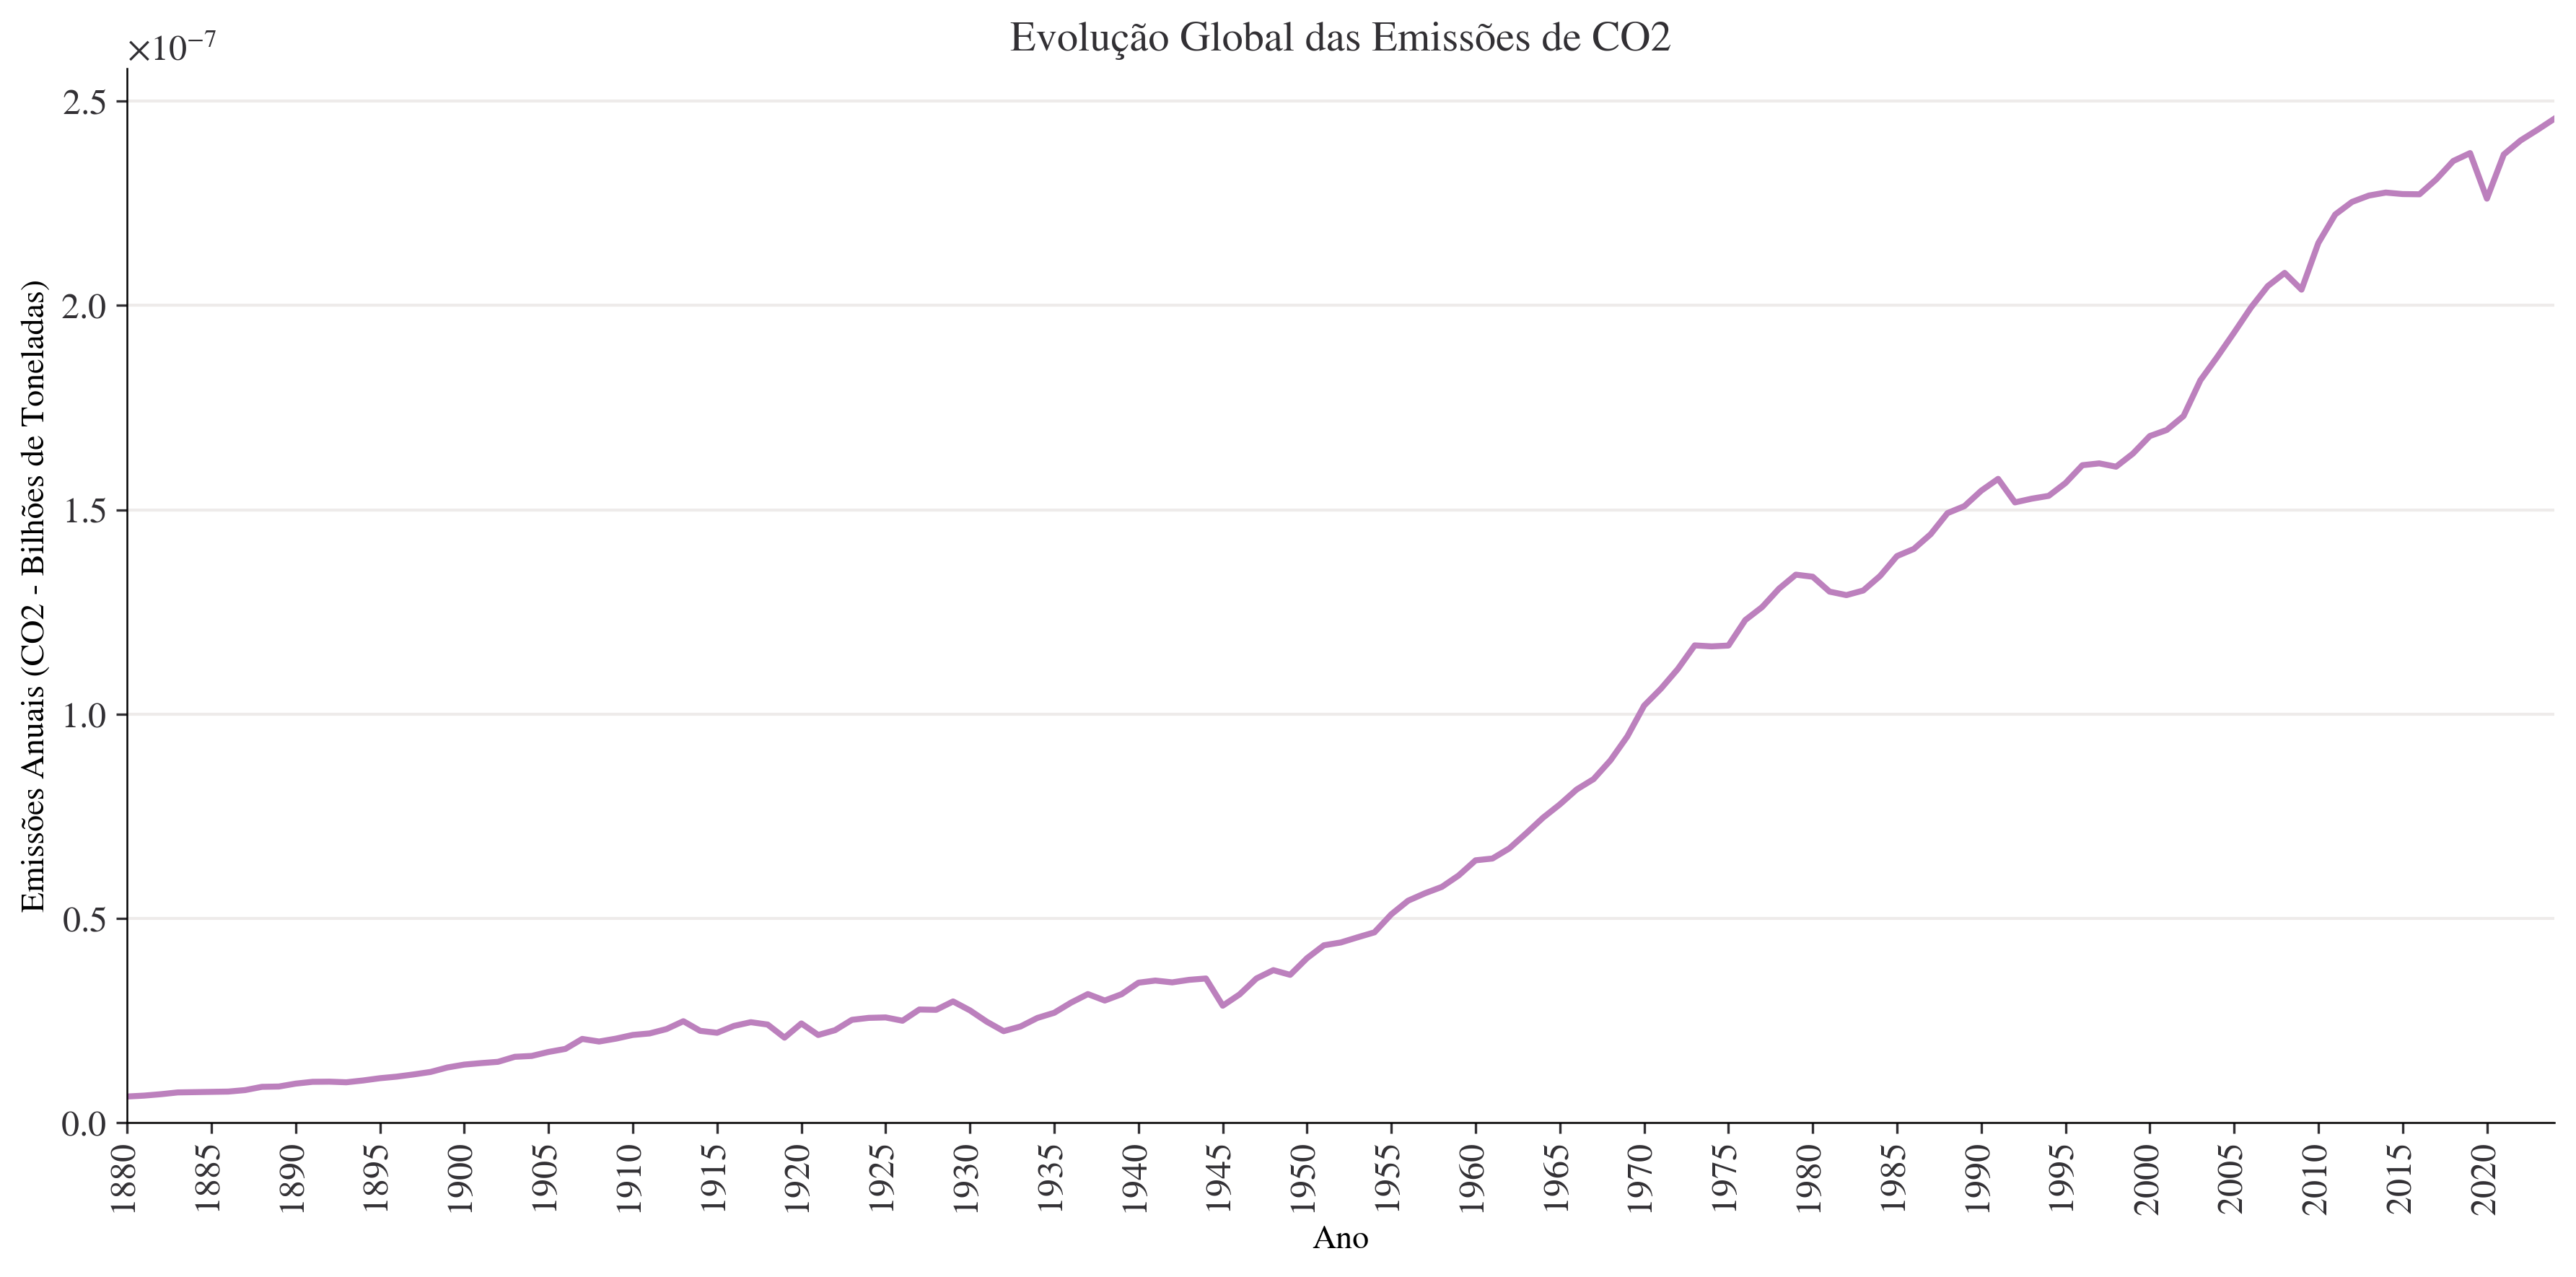

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_co2['Ano'], df_co2['total_emissoes'] / 1e9, linewidth=2)

ax.set_title("Evolução Global das Emissões de CO2", fontsize=14, loc="center")
ax.set_ylabel("Emissões Anuais (CO2 - Bilhões de Toneladas)", fontsize=11)
ax.set_xlabel("Ano", fontsize=11)


ax.set_xlim(1880, df_co2['Ano'].max())
ax.set_ylim(0, None)


ax.xaxis.set_major_locator(MultipleLocator(5))
ax.grid(True, alpha=0.7, linewidth=1, axis='y')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
df_temp_co2 = pd.merge(df_co2, df, on="Ano")
df_temp_co2[["Ano", "total_emissoes", "anomalia_anual"]]

,Ano,total_emissoes,anomalia_anual
0,1880,6.441066,-0.18
1,1881,6.655349,-0.09
2,1882,7.001336,-0.12
3,1883,7.437984,-0.18
4,1884,7.501581,-0.29
...,...,...,...
140,2020,226.123155,1.01
141,2021,236.932334,0.85
142,2022,240.370224,0.89
143,2023,242.955626,1.17


### Regressão Linear


In [ ]:
y = df_temp_co2['anomalia_anual']
X = df_temp_co2['total_emissoes']

X_com_constante = sm.add_constant(X)

modelo = sm.OLS(y, X_com_constante).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         anomalia_anual   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     910.4
Date:                Wed, 04 Feb 2026   Prob (F-statistic):           7.03e-64
Time:                        10:39:32   Log-Likelihood:                 75.018
No. Observations:                 145   AIC:                            -146.0
Df Residuals:                     143   BIC:                            -140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3308      0.018    -18.

/tmp/ipython-input-2838972700.py:29: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) STIXGeneral.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)


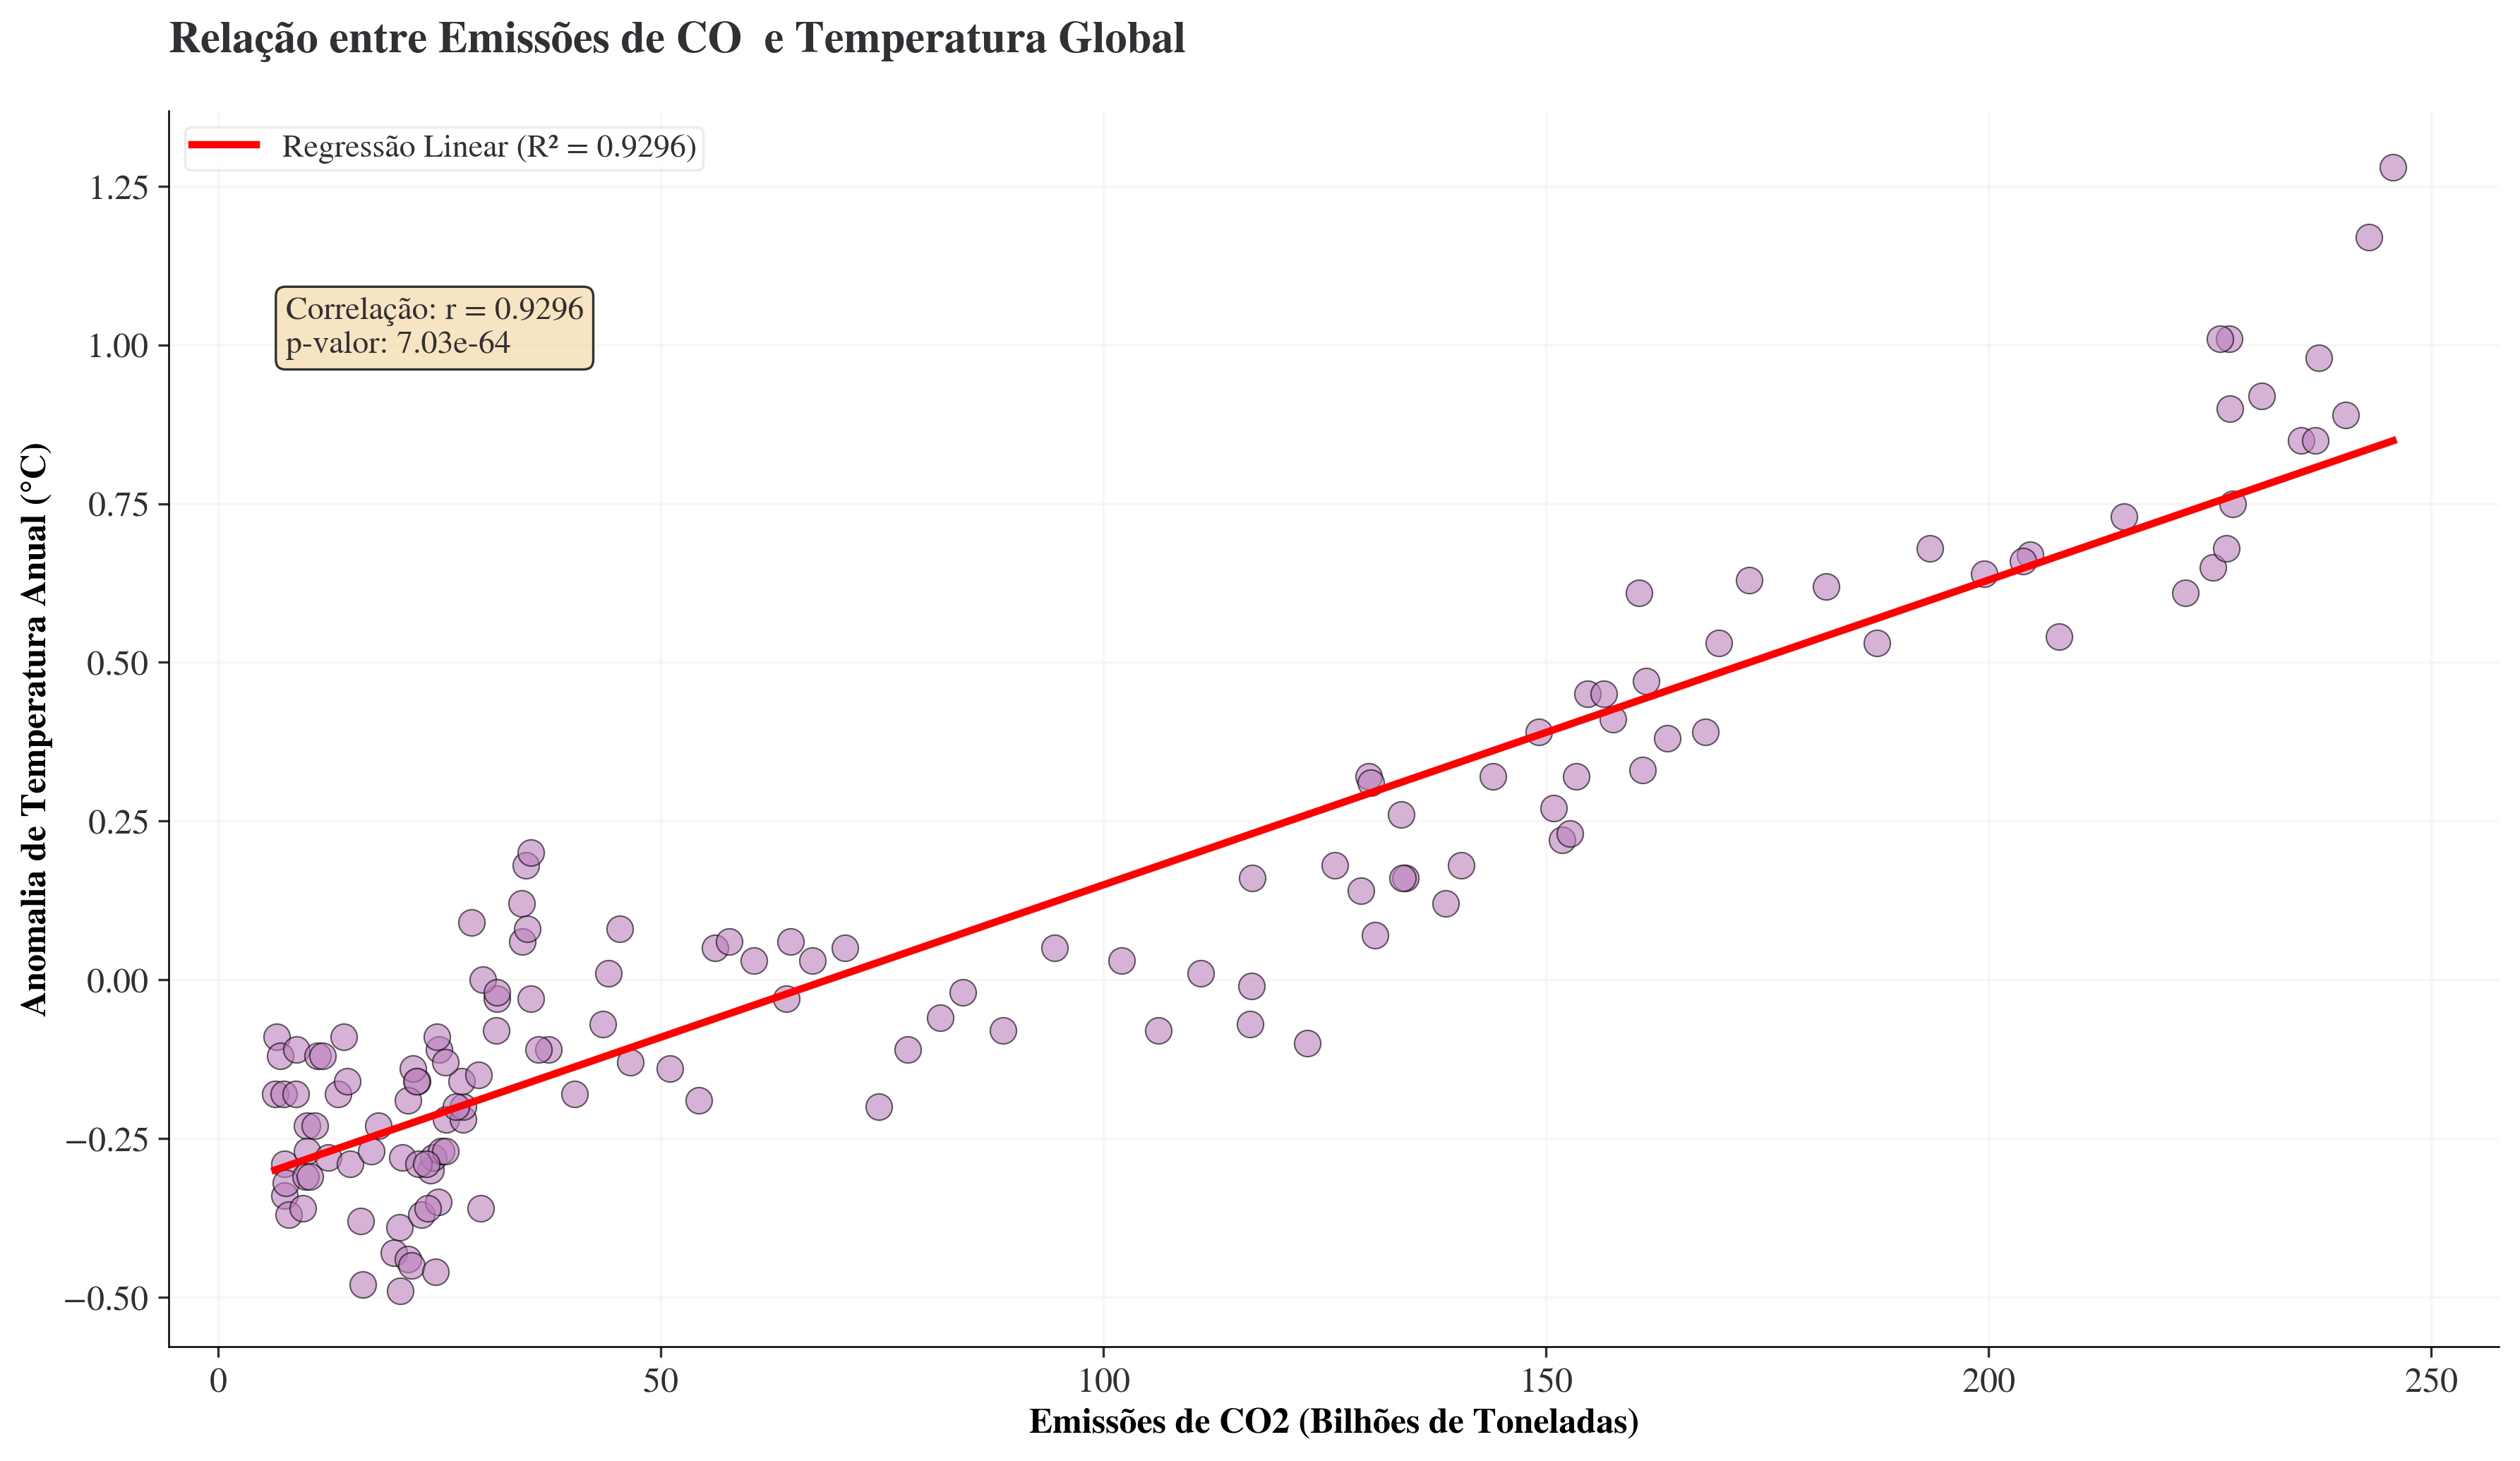

In [ ]:
intercepto = modelo.params['const']
inclinacao = modelo.params['total_emissoes']
r2 = modelo.rsquared
p_valor = modelo.pvalues['total_emissoes']

r2 = df_temp_co2['total_emissoes'].corr(df_temp_co2['anomalia_anual'])

fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(X, y, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)

x_linha = np.array([X.min(), X.max()])
y_linha = inclinacao * x_linha + intercepto

ax.plot(x_linha, y_linha, 'r-', linewidth=2.5,
        label=f'Regressão Linear (R² = {r2:.4f})')

ax.set_xlabel('Emissões de CO2 (Bilhões de Toneladas)', fontsize=12, fontweight='bold')
ax.set_ylabel('Anomalia de Temperatura Anual (°C)', fontsize=12, fontweight='bold')
ax.set_title('Relação entre Emissões de CO₂ e Temperatura Global',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

textstr = f'Correlação: r = {r2:.4f}\np-valor: {p_valor:.2e}'
ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
res_temp = adfuller(df['anomalia_anual'])
print(f"Teste de ADF a 5%: {res_temp[1]:.3f}")

Teste de ADF a 5%: 0.998


O modelo apresenta um $R^2$ elevado, mas pode-se tratar de uma correlação
espúria, isto é, que as váriaveis seriam coincidências do que uma causalidade mostrando um resultado enganoso.

O teste ADF confirmou que as séries não são estacionárias, isto é, elas crescem sem parar ao longo do tempo (possuem tendência), o que confunde o modelo.

A estatística Durbin-Watson (próxima de zero) revelou forte autocorrelação nos resíduos,isto é, indicando que o modelo não estava conseguindo explicar o padrão real dos dados, invalidando a significância estatística dos coeficientes.

No caso a próxima etapa é diferenciar as váriaveis e defasar o modelo, para verificar se o efeito demora um tempo para aparecer. No caso, isso é subtrai o valor do ano atual pelo do ano anterior para remover a tendência de subida




In [ ]:
## Diferenciando as váriaveis

df_temp_co2['diff_temp'] = df_temp_co2['anomalia_anual'].diff()
df_temp_co2['diff_co2'] = df_temp_co2['total_emissoes'].diff()

df_temp_co2_diff = df_temp_co2.dropna()

correlacao_real = df_temp_co2_diff['diff_temp'].corr(df_temp_co2_diff['diff_co2'])
print(f"Correlação nas diferenças: {correlacao_real:.2f}")

Correlação nas diferenças: -0.07


In [ ]:
# Criamos o LAG apenas no CO2 (Empurramos o CO2 um ano para o passado)
df_temp_co2['diff_co2_lag1'] = df_temp_co2['diff_co2'].shift(1)

df_lagged = df_temp_co2.dropna(subset=['diff_temp', 'diff_co2_lag1'])

# Y = Temperatura de Hoje (diff_temp)
# X = CO2 de Ontem (diff_co2_lag1)
modelo_lagged = sm.OLS(df_lagged['diff_temp'], sm.add_constant(df_lagged['diff_co2_lag1'])).fit()
print(modelo_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:              diff_temp   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     3.911
Date:                Wed, 04 Feb 2026   Prob (F-statistic):             0.0499
Time:                        10:39:34   Log-Likelihood:                 110.86
No. Observations:                 143   AIC:                            -217.7
Df Residuals:                     141   BIC:                            -211.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.011     -0.101

Pode-se reparar que o $R^2$ teve uma queda de 92% para 2,7% e o teste de DBW se aproximou do valor de 2, indicando que a série não possui mais a correlação entre as variáveis. O Gráfico abaixo mostra ao defasar a variavel de CO2 não há tanta relação quanto antes

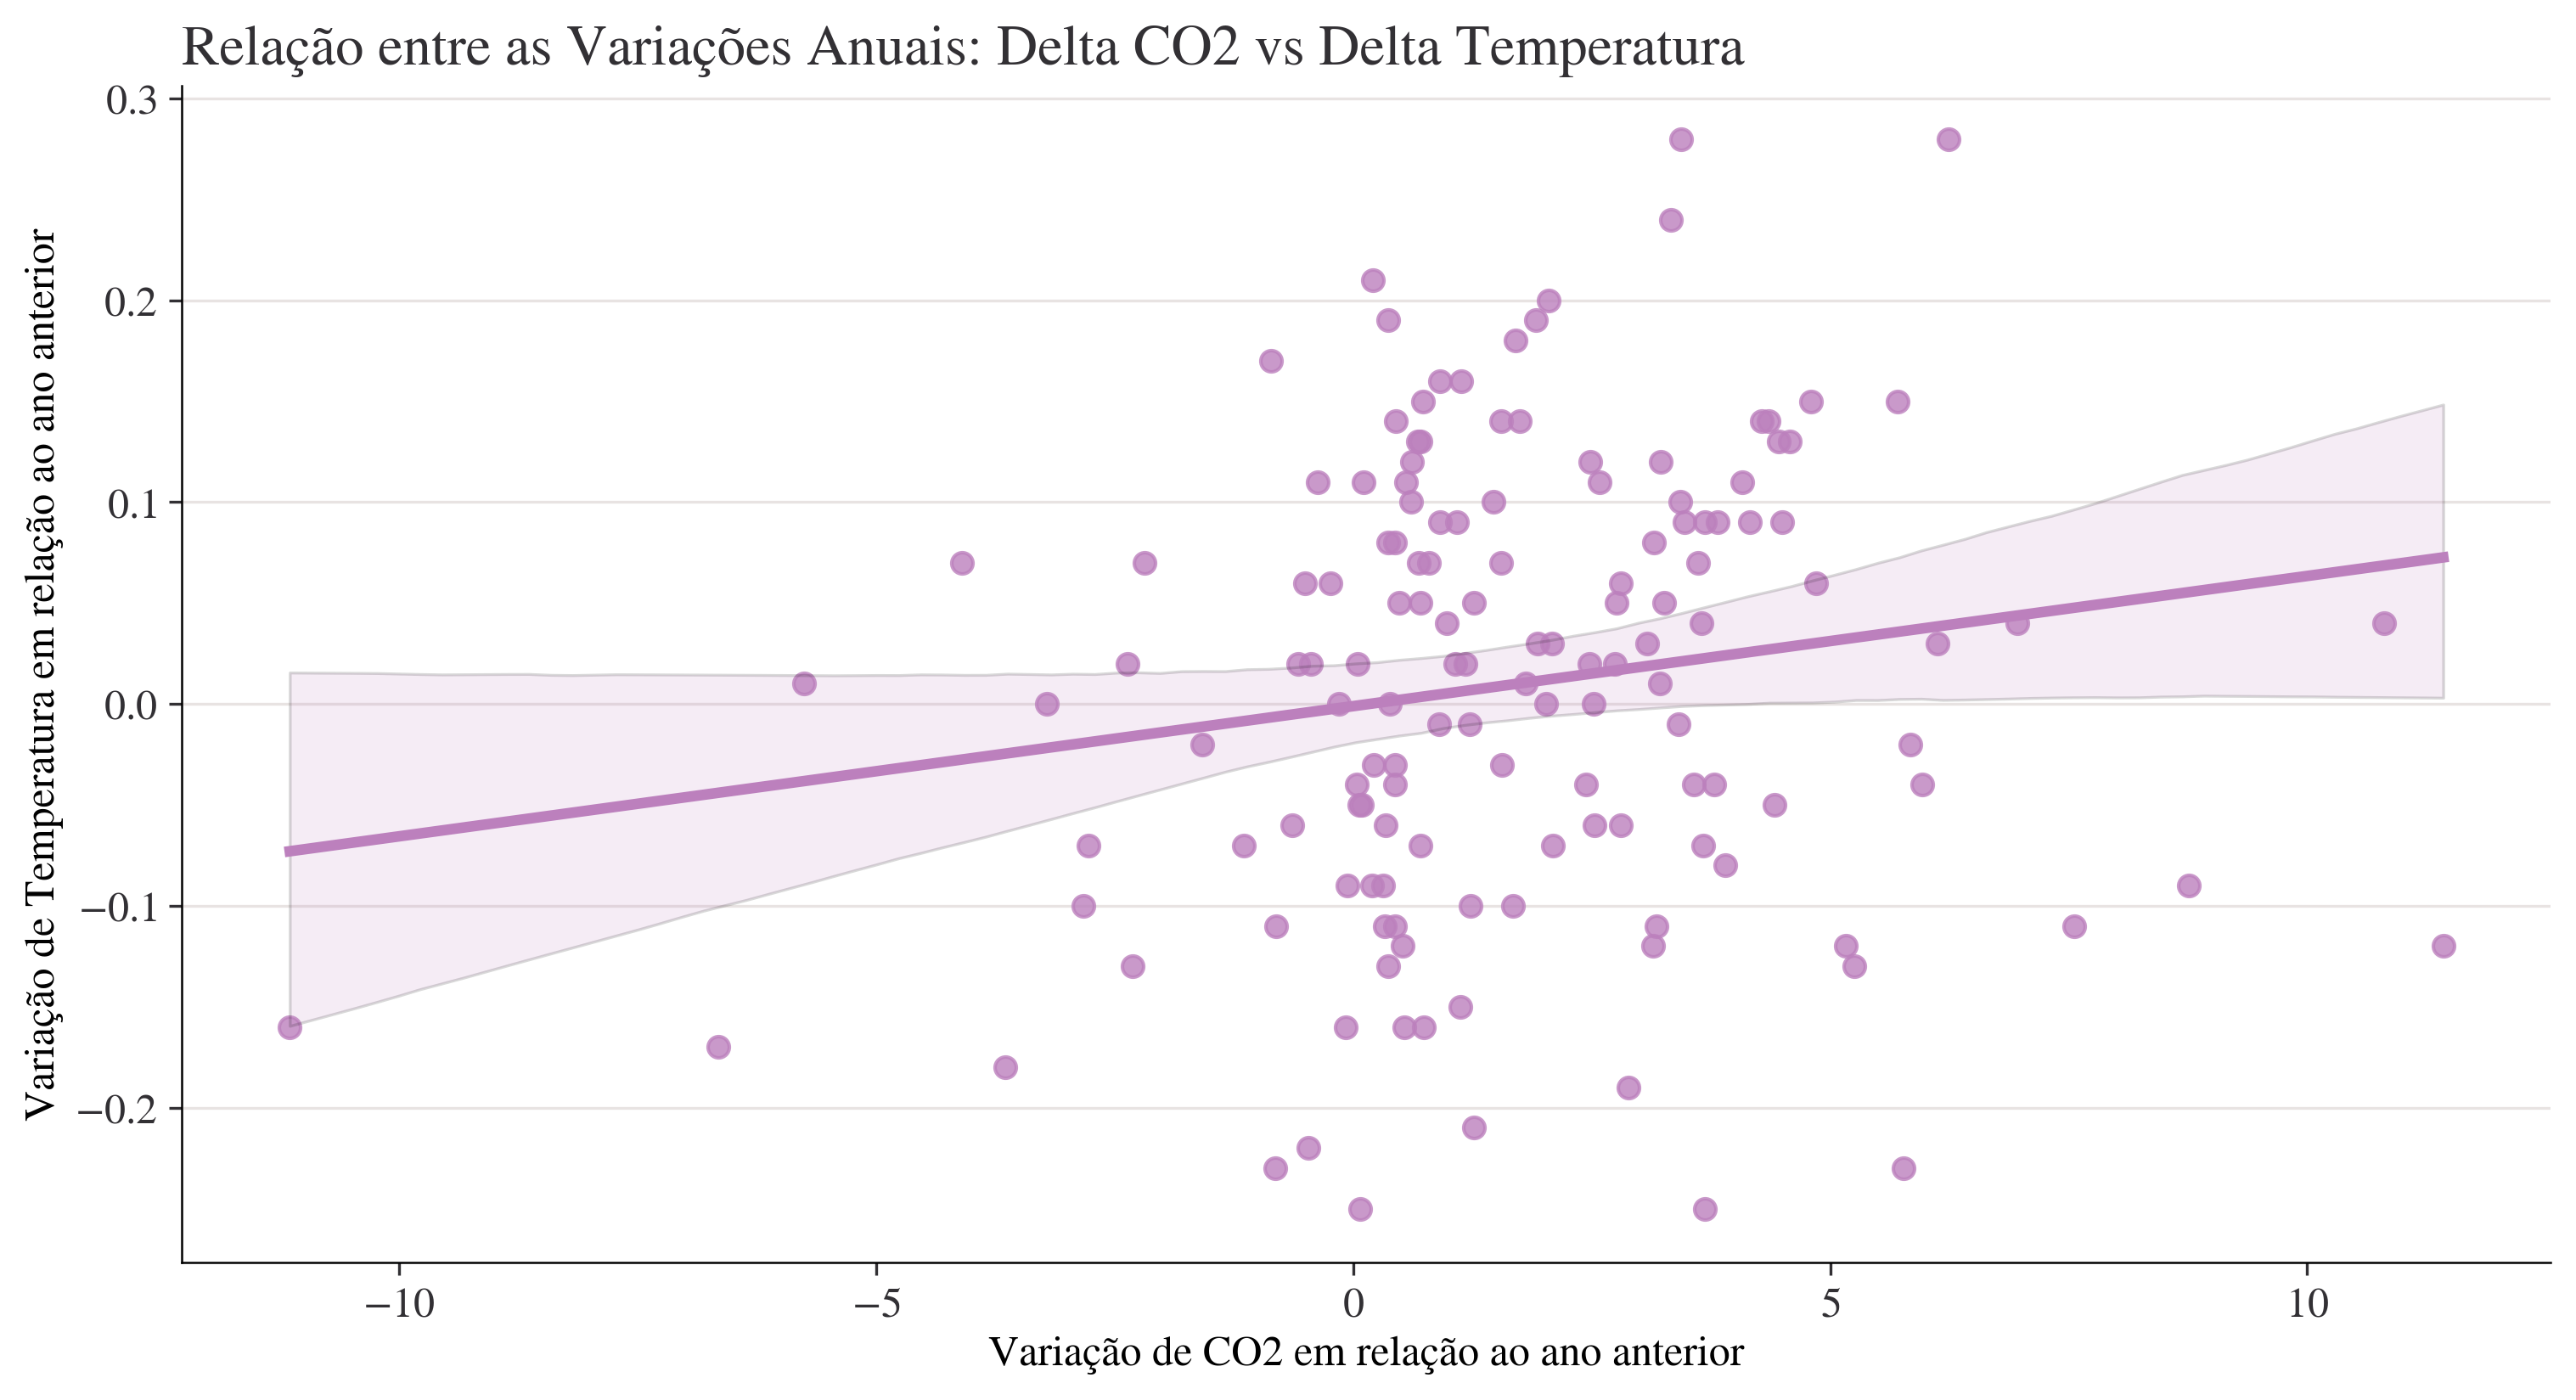

In [ ]:
plt.figure(figsize=(12, 6))
sns.regplot(data=df_temp_co2, x='diff_co2_lag1', y='diff_temp')
plt.title("Relação entre as Variações Anuais: Delta CO2 vs Delta Temperatura")
plt.xlabel("Variação de CO2 em relação ao ano anterior")
plt.ylabel("Variação de Temperatura em relação ao ano anterior")
plt.show()

## El Niño
A análise inicial sugeriu que a correlação entre CO₂ e temperatura poderia estar sofrendo de viés de variável omitida. Após pesquisas e discussões técnicas com especialistas da área ambiental, incorporei ao modelo o ONI (Oceanic Niño Index).

A adição desta variável visa capturar a influência dos ciclos naturais do oceano (El Niño/La Niña), permitindo distinguir com maior precisão o impacto das emissões antrópicas (CO2) das oscilações climáticas naturais.

In [ ]:
nino = (
    pd.read_csv(
    "https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt",
    sep='\s+'
    )
    .rename(columns={"YR":"Ano","ANOM":"oni_anual_medio"})
    .groupby('Ano')['oni_anual_medio'].mean()
    .reset_index()

)
nino

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1229845563.py:4: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+'


,Ano,oni_anual_medio
0,1950,-0.858333
1,1951,0.437500
2,1952,0.155833
3,1953,0.727500
4,1954,-0.410833
...,...,...
72,2022,-0.850833
73,2023,0.910000
74,2024,0.435833
75,2025,-0.274167


In [ ]:
df_final = pd.merge(df_temp_co2, nino, on='Ano', how='inner')
df_final['diff_co2_lag1'] = df_final['diff_co2'].shift(1)
df_final['diff_oni'] = df_final['oni_anual_medio'].diff()

df_final = df_final.dropna(subset=['diff_temp', 'diff_co2_lag1', 'diff_oni'])

# Y = Temperatura de Hoje
# X1 = CO2 do Ano Passado (Efeito Estufa com atraso)
# X2 = El Niño de Hoje (Variabilidade Natural)
X_multivar = df_final[['diff_co2_lag1', 'diff_oni']]
X_multivar = sm.add_constant(X_multivar)
y_multivar = df_final['diff_temp']

modelo_multivariado = sm.OLS(y_multivar, X_multivar).fit()

print("RESULTADO FINAL: CO2 DEFASADO + EL NIÑO")
print(modelo_multivariado.summary())

RESULTADO FINAL: CO2 DEFASADO + EL NIÑO
                            OLS Regression Results                            
Dep. Variable:              diff_temp   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     5.042
Date:                Wed, 04 Feb 2026   Prob (F-statistic):            0.00897
Time:                        10:39:36   Log-Likelihood:                 56.951
No. Observations:                  74   AIC:                            -107.9
Df Residuals:                      71   BIC:                            -101.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

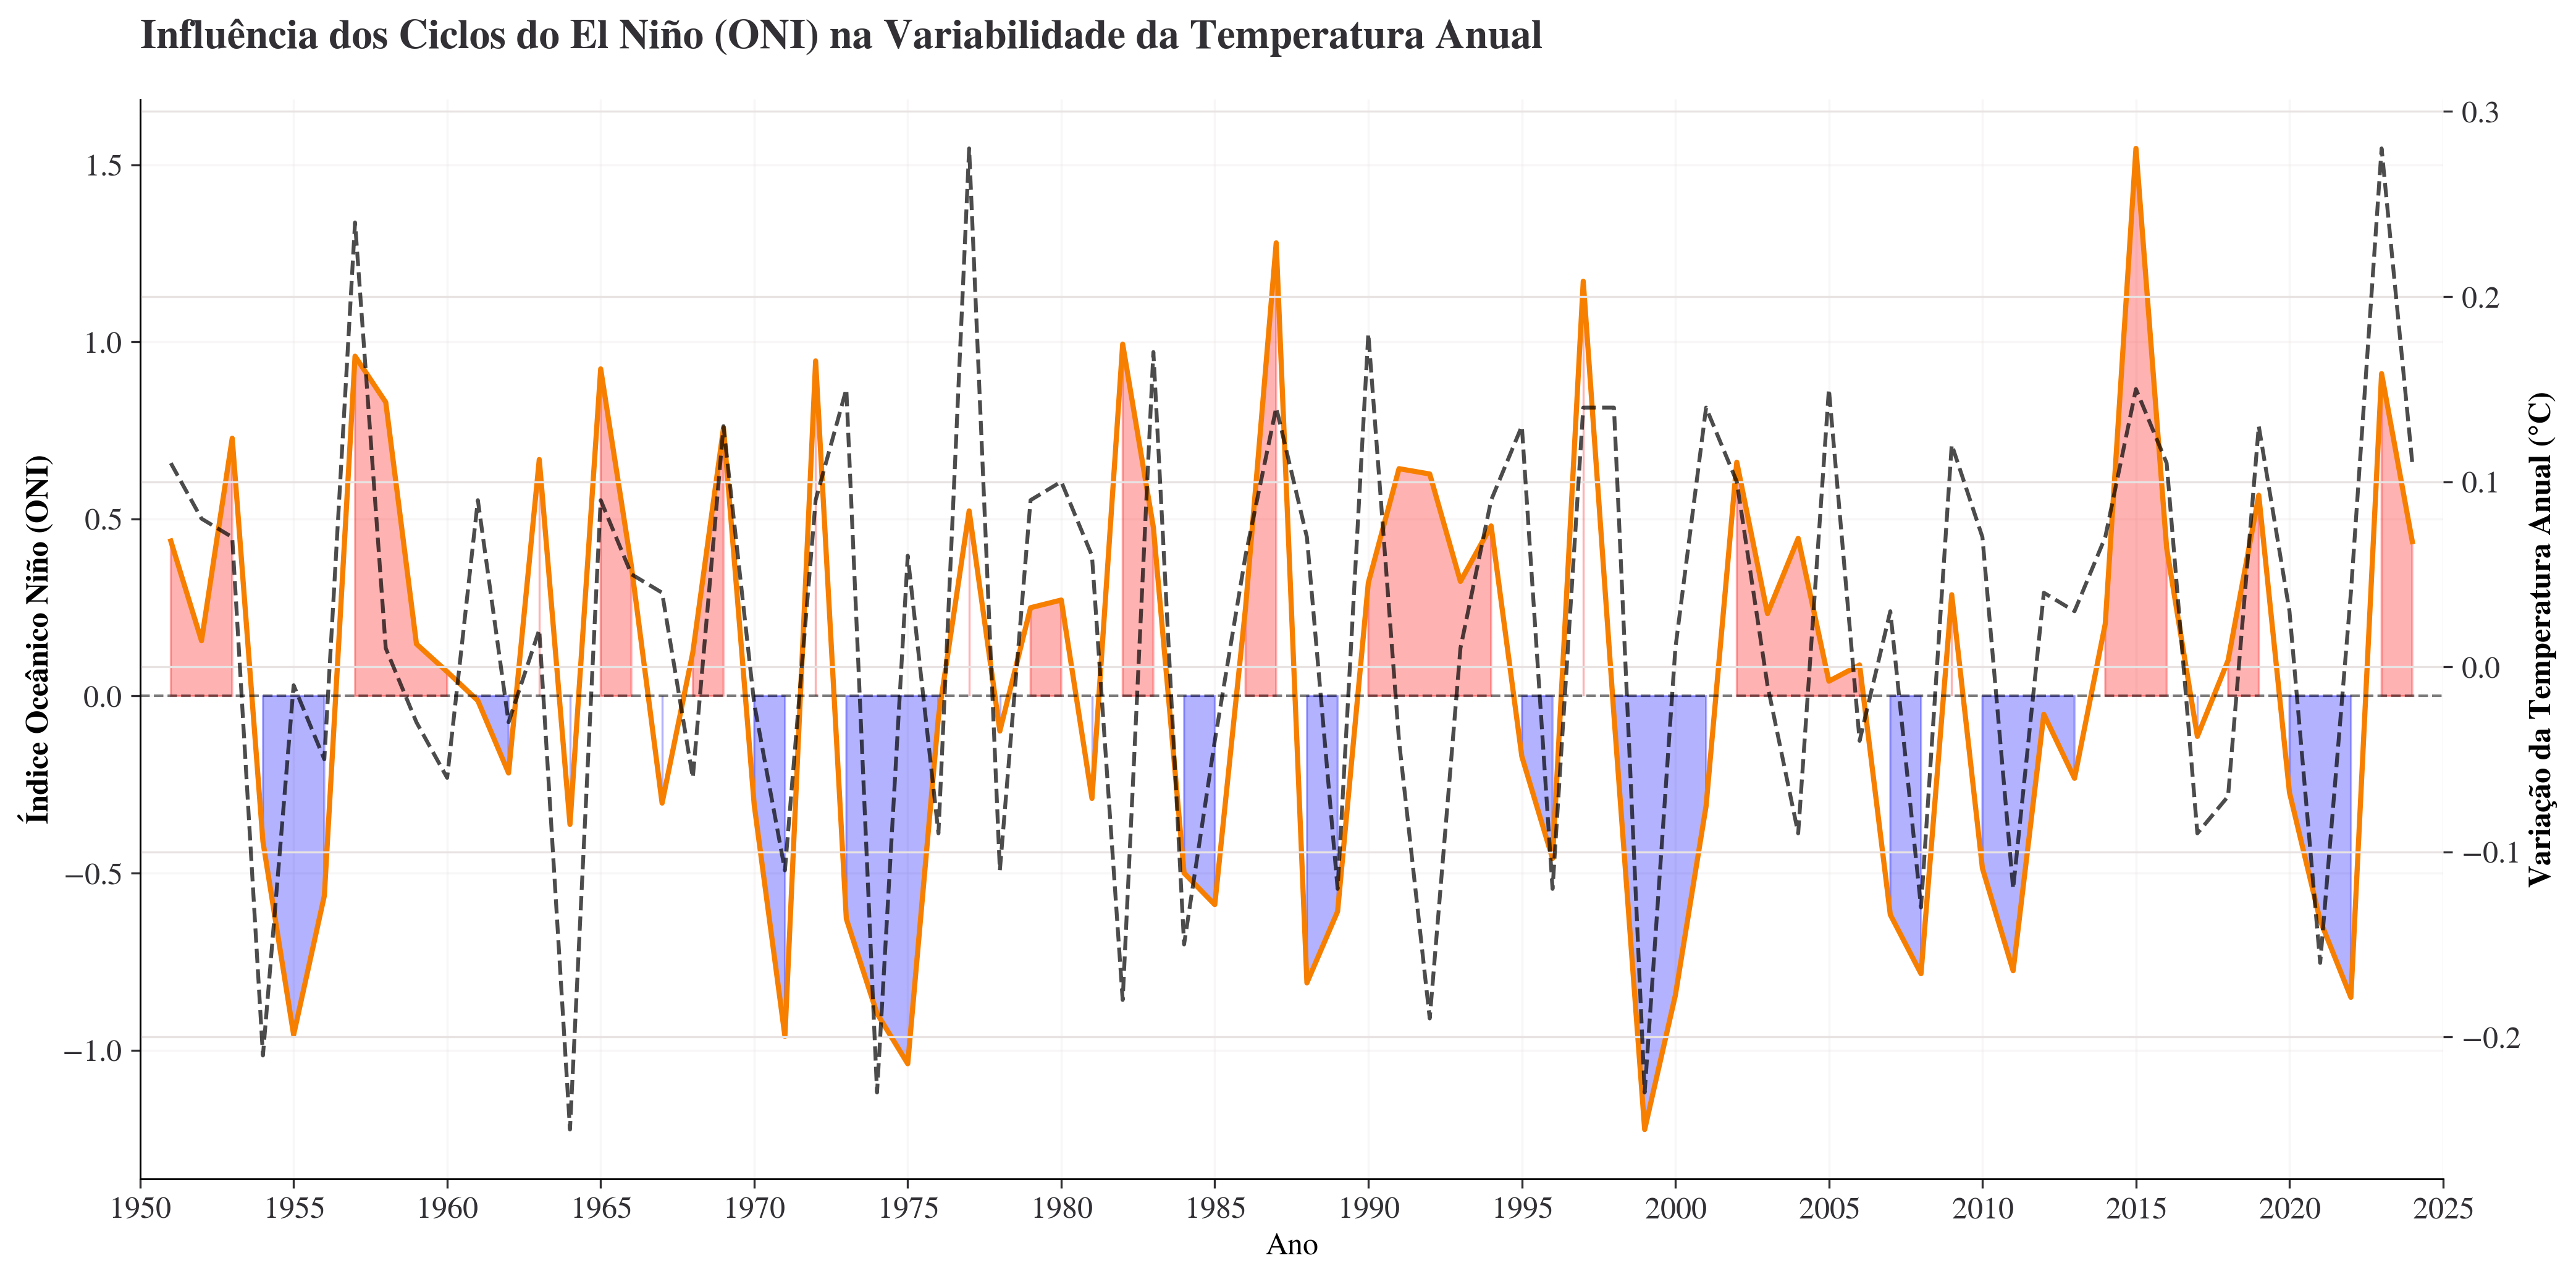

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(df_final['Ano'], df_final['oni_anual_medio'], linewidth=2, color='#F77F00', label='Índice ONI')
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlim(1950,2025)


ax1.fill_between(df_final['Ano'], df_final['oni_anual_medio'], 0,
                 where=df_final['oni_anual_medio'] > 0, alpha=0.3, color='red', label='El Niño (Aquecimento)')
ax1.fill_between(df_final['Ano'], df_final['oni_anual_medio'], 0,
                 where=df_final['oni_anual_medio'] < 0, alpha=0.3, color='blue', label='La Niña (Resfriamento)')

ax1.set_ylabel('Índice Oceânico Niño (ONI)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='y')
ax1.set_xlabel('Ano', fontsize=12)


ax2 = ax1.twinx()
ax2.plot(df_final['Ano'], df_final['diff_temp'], color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Variação da Temp. Global')
ax2.set_ylabel('Variação da Temperatura Anual (°C)', fontsize=12, fontweight='bold', color='black')

# Título e Legendas
plt.title('Influência dos Ciclos do El Niño (ONI) na Variabilidade da Temperatura Anual', fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.xaxis.set_major_locator(MultipleLocator(5))

plt.tight_layout()
plt.show()